In [1]:
import collections
import pandas as pd
import numpy as np
import project_tests as tests
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import LSTM, GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Load Data

In [2]:
input_file = 'data/small_vocab_en'
with open(input_file, "r") as f:
    data = f.read()
    english_sentences = data.split('\n')    

In [3]:
english_sentences[0]

'new jersey is sometimes quiet during autumn , and it is snowy in april .'

In [4]:
input_file = 'data/small_vocab_fr'
with open(input_file, "r") as f:
    data = f.read()
    french_sentences = data.split('\n')   

In [5]:
french_sentences[0]

"new jersey est parfois calme pendant l' automne , et il est neigeux en avril ."

# Vocabulary

In [6]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))

1823250 English words.
227 unique English words.


In [7]:
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(french_words_counter)))

1961295 French words.
355 unique English words.


## Data Preprocessing

you won't use text data as input to your model. Instead, you'll convert the text into sequences of integers using the following preprocess methods:

1. Tokenize the words into ids
2. Add padding to make all the sequences the same length.

### Tokenization 
Turn each sentence into a sequence of words ids using Keras's Tokenizer

In [8]:
def tokenize(x):
    # Create the tokeninzer
    t = Tokenizer()
    # Create dictionary mapping words (str) to their rank/index (int)
    t.fit_on_texts(x)
    # Use the tokenizer to tokenize the text
    text_sequences = t.texts_to_sequences(x)
    return text_sequences, t

tests.test_tokenize(tokenize)

## Padding

In [9]:
def pad(x, length=None):
    # If length equals None, set it to be the length of the longest sequence in x
    if length == None:
        length = len(max(x, key=len))
        
    # Use Keras's pad_sequences to pad the sequences with 0's
    padded_sequences = pad_sequences(sequences=x, maxlen=length, padding='post', value=0)
    
    return padded_sequences

tests.test_pad(pad)

In [10]:
def preprocess(x, y):
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

In [11]:
preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer = preprocess(english_sentences, french_sentences)

In [12]:
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

In [13]:
print("Max English sentence length :", max_english_sequence_length)
print("Max French sentence length  :", max_french_sequence_length)
print("English vocabulary size     :", english_vocab_size)
print("French vocabulary size      :", french_vocab_size)

Max English sentence length : 15
Max French sentence length  : 21
English vocabulary size     : 199
French vocabulary size      : 345


# Split the data

In [14]:
english_sentences_train, english_sentences_test, french_sentences_train, french_sentences_test = train_test_split(english_sentences, french_sentences, test_size=0.2, random_state=42)

In [15]:
print("training data :",len(english_sentences_train))
print("testing data  :",len(english_sentences_test))

training data : 110288
testing data  : 27573


In [16]:
english_train_words_counter = collections.Counter([word for sentence in english_sentences_train for word in sentence.split()])
french_train_words_counter = collections.Counter([word for sentence in french_sentences_train for word in sentence.split()])
print('English words in the training set : {}'.format(len([word for sentence in english_sentences_train for word in sentence.split()])))
print('French words in the training set  : {}'.format(len([word for sentence in french_sentences_train for word in sentence.split()])))

English words in the training set : 1458806
French words in the training set  : 1568964


In [17]:
english_test_words_counter = collections.Counter([word for sentence in english_sentences_test for word in sentence.split()])
french_test_words_counter = collections.Counter([word for sentence in french_sentences_test for word in sentence.split()])
print('English words in the test set : {}'.format(len([word for sentence in english_sentences_test for word in sentence.split()])))
print('French words in the test set  : {}'.format(len([word for sentence in french_sentences_test for word in sentence.split()])))

English words in the test set : 364444
French words in the test set  : 392331


# Preprocess the training data

In [18]:
preproc_english_sentences_train, preproc_french_sentences_train, english_tokenizer_train, french_tokenizer_train = preprocess(english_sentences_train, french_sentences_train)

max_english_sequence_length_train = preproc_english_sentences_train.shape[1]
max_french_sequence_length_train = preproc_french_sentences_train.shape[1]
english_vocab_size_train = len(english_tokenizer_train.word_index)
french_vocab_size_train = len(french_tokenizer_train.word_index)

# Preprocess the testing data

In [19]:
preproc_english_sentences_test, preproc_french_sentences_test, english_tokenizer_test, french_tokenizer_test = preprocess(english_sentences_test, french_sentences_test)

max_english_sequence_length_test = preproc_english_sentences_test.shape[1]
max_french_sequence_length_test = preproc_french_sentences_test.shape[1]
english_vocab_size_test = len(english_tokenizer_test.word_index)
french_vocab_size_test = len(french_tokenizer_test.word_index)

# RNN Model

In [20]:
# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

input_shape = tmp_x.shape

output_sequence_length = max_french_sequence_length
english_vocab_size = english_vocab_size + 1
french_vocab_size  = french_vocab_size + 1

In [21]:
# Input layer
input_layer = Input(shape=input_shape[1:])
# GRU Layer
x = GRU(output_sequence_length, return_sequences=True)(input_layer)
# Fully-connected Layer
x = Dense(french_vocab_size*4, activation='relu')(x)
# Output Layer
output_layer = Dense(french_vocab_size, activation='softmax')(x)
# Create model
model = Model(inputs=input_layer, outputs=output_layer)

In [22]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21, 1)             0         
_________________________________________________________________
gru_1 (GRU)                  (None, 21, 21)            1449      
_________________________________________________________________
dense_1 (Dense)              (None, 21, 1384)          30448     
_________________________________________________________________
dense_2 (Dense)              (None, 21, 346)           479210    
Total params: 511,107
Trainable params: 511,107
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Compile the model
model.compile( loss=sparse_categorical_crossentropy,
               optimizer=Adam(lr = 0.01),
               metrics=['accuracy'])

In [45]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 21)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 21, 204)           104448    
_________________________________________________________________
gru_3 (GRU)                  (None, 21, 512)           1101312   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 21, 1400)          718200    
_________________________________________________________________
dense_4 (Dense)              (None, 21, 350)           490350    
Total params: 2,414,310
Trainable params: 2,414,310
Non-trainable params: 0
_________________________________________________________________


In [24]:
%time history = model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)

Train on 110288 samples, validate on 27573 samples
Epoch 1/10
110288/110288 [==============================] - 15s 132us/step - loss: 2.0208 - accuracy: 0.5406 - val_loss: 1.4723 - val_accuracy: 0.6048
Epoch 2/10
110288/110288 [==============================] - 12s 112us/step - loss: 1.3649 - accuracy: 0.6253 - val_loss: 1.2804 - val_accuracy: 0.6420
Epoch 3/10
110288/110288 [==============================] - 12s 107us/step - loss: 1.2236 - accuracy: 0.6510 - val_loss: 1.1684 - val_accuracy: 0.6615
Epoch 4/10
110288/110288 [==============================] - 12s 109us/step - loss: 1.1421 - accuracy: 0.6645 - val_loss: 1.1120 - val_accuracy: 0.6702
Epoch 5/10
110288/110288 [==============================] - 12s 112us/step - loss: 1.0919 - accuracy: 0.6729 - val_loss: 1.0642 - val_accuracy: 0.6790
Epoch 6/10
110288/110288 [==============================] - 12s 108us/step - loss: 1.0525 - accuracy: 0.6788 - val_loss: 1.0412 - val_accuracy: 0.6817
Epoch 7/10
110288/110288 [=================

In [25]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

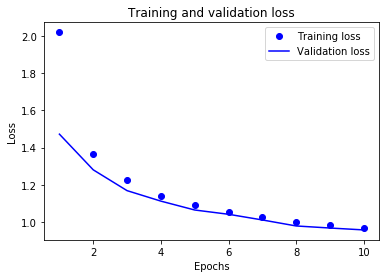

In [26]:
import matplotlib.pyplot as plt
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

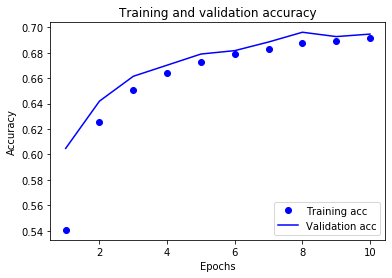

In [27]:
plt.clf() 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Testing

In [28]:
def logits_to_text(logits, tokenizer):
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

In [29]:
# Reshape the test data 
test_x = pad(preproc_english_sentences_test, max_french_sequence_length_test)
test_x = test_x.reshape((-1, preproc_french_sentences_train.shape[-2], 1))

# Rehsape the test label data to fit the model
preproc_french_sentences_test = preproc_french_sentences_test.reshape((-1, preproc_french_sentences_train.shape[-2], 1))

# Evaluate the model on the unseen test data
simple_rnn_model_score = model.evaluate(test_x, preproc_french_sentences_test, verbose=0)

print("Simple model accuracy on unseen test dataset: {0:.2f}%".format(simple_rnn_model_score[1]*100))

Simple model accuracy on unseen test dataset: 45.42%


In [34]:
print(logits_to_text(model.predict(tmp_x[:1])[0], french_tokenizer_train))

new jersey est parfois calme en mois et il et est en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


 # RNN with  Embedding 

In [40]:
# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, preproc_french_sentences.shape[1])

input_shape = tmp_x.shape

output_sequence_length = max_french_sequence_length
english_vocab_size = english_vocab_size + 1
french_vocab_size  = french_vocab_size + 1

In [41]:
input_layer = Input(shape=input_shape[1:])
embedding_layer = Embedding(512, english_vocab_size)(input_layer)
x = GRU(512, return_sequences=True)(embedding_layer)
x = TimeDistributed(Dense(french_vocab_size*4, activation='relu'))(x)
output_layer = Dense(french_vocab_size, activation='softmax')(x)
    
model = Model(inputs=input_layer, outputs=output_layer)

In [56]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 21, 1)             0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 21, 1024)          1579008   
_________________________________________________________________
dense_5 (Dense)              (None, 21, 702)           719550    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 21, 351)           246753    
Total params: 2,545,311
Trainable params: 2,545,311
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Compile the model
model.compile( loss=sparse_categorical_crossentropy,
               optimizer=Adam(lr = 0.01),
               metrics=['accuracy'])

In [44]:
%time history = model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)

C:\Users\harka\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 110288 samples, validate on 27573 samples
Epoch 1/10
110288/110288 [==============================] - 287s 3ms/step - loss: 3.5145 - accuracy: 0.4961 - val_loss: 2.1084 - val_accuracy: 0.6100
Epoch 2/10
110288/110288 [==============================] - 317s 3ms/step - loss: 1.9449 - accuracy: 0.6397 - val_loss: 1.8400 - val_accuracy: 0.6624
Epoch 3/10
110288/110288 [==============================] - 301s 3ms/step - loss: 1.7088 - accuracy: 0.6959 - val_loss: 1.8476 - val_accuracy: 0.6715
Epoch 4/10
110288/110288 [==============================] - 284s 3ms/step - loss: 1.5484 - accuracy: 0.7354 - val_loss: 1.4368 - val_accuracy: 0.7613
Epoch 5/10
110288/110288 [==============================] - 302s 3ms/step - loss: 1.3745 - accuracy: 0.7782 - val_loss: 1.3100 - val_accuracy: 0.7959
Epoch 6/10
110288/110288 [==============================] - 304s 3ms/step - loss: 1.2806 - accuracy: 0.8030 - val_loss: 1.2551 - val_accuracy: 0.8090
Epoch 7/10
110288/110288 [=======================

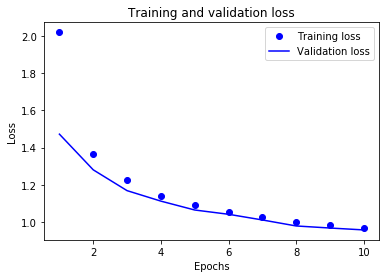

In [46]:
import matplotlib.pyplot as plt
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

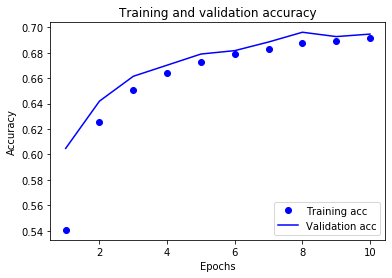

In [47]:
plt.clf() 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [48]:
def logits_to_text(logits, tokenizer):
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

# Test Data

In [51]:
test_x = pad(preproc_english_sentences_test, max_french_sequence_length_test)
test_x = test_x.reshape((-1, preproc_french_sentences_train.shape[-2]))

embedding_model_score = model.evaluate(test_x, preproc_french_sentences_test, verbose=0)

print("Embedding model accuracy on unseen test data: {0:.2f}%".format(embedding_model_score[1]*100))

Embedding model accuracy on unseen test data: 39.99%


In [52]:
print(logits_to_text(model.predict(tmp_x[:1])[0], french_tokenizer_train))

mon jersey est parfois calme en l' de il est neigeux en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


# Bidirectional RNN

In [53]:
# Pad the input
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

input_shape = tmp_x.shape
output_sequence_length = max_french_sequence_length
english_vocab_size = english_vocab_size + 1
french_vocab_size  = french_vocab_size + 1

In [54]:
# Build the bidirectional RNN model
input_layer = Input(shape=input_shape[1:])
x = Bidirectional(GRU(512, return_sequences=True, recurrent_dropout=0.2))(input_layer)
x = Dense(french_vocab_size*2, activation='relu')(x)
output_layer = TimeDistributed(Dense(french_vocab_size, activation='softmax'))(x)
    
model = Model(inputs=input_layer, outputs=output_layer)

In [55]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 21, 1)             0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 21, 1024)          1579008   
_________________________________________________________________
dense_5 (Dense)              (None, 21, 702)           719550    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 21, 351)           246753    
Total params: 2,545,311
Trainable params: 2,545,311
Non-trainable params: 0
_________________________________________________________________


In [57]:
# Compile the model
model.compile( loss=sparse_categorical_crossentropy,
               optimizer=Adam(lr = 0.01),
               metrics=['accuracy'])

In [59]:
%time history = model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)

Train on 110288 samples, validate on 27573 samples
Epoch 1/10
110288/110288 [==============================] - 315s 3ms/step - loss: 3.2139 - accuracy: 0.4626 - val_loss: 4.3405 - val_accuracy: 0.0825
Epoch 2/10
110288/110288 [==============================] - 323s 3ms/step - loss: 1.7023 - accuracy: 0.5583 - val_loss: 4.3138 - val_accuracy: 0.1333
Epoch 3/10
110288/110288 [==============================] - 307s 3ms/step - loss: 1.5575 - accuracy: 0.5849 - val_loss: 4.2317 - val_accuracy: 0.1913
Epoch 4/10
110288/110288 [==============================] - 180s 2ms/step - loss: 1.4880 - accuracy: 0.5977 - val_loss: 4.3256 - val_accuracy: 0.1539
Epoch 5/10
110288/110288 [==============================] - 173s 2ms/step - loss: 1.4459 - accuracy: 0.6071 - val_loss: 4.4011 - val_accuracy: 0.1783
Epoch 6/10
110288/110288 [==============================] - 174s 2ms/step - loss: 1.4098 - accuracy: 0.6139 - val_loss: 4.5386 - val_accuracy: 0.2035
Epoch 7/10
110288/110288 [=======================

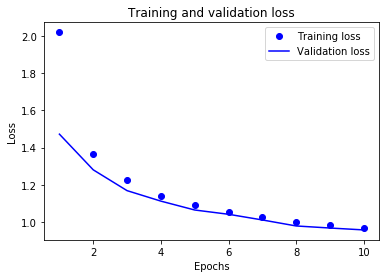

In [60]:
import matplotlib.pyplot as plt
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

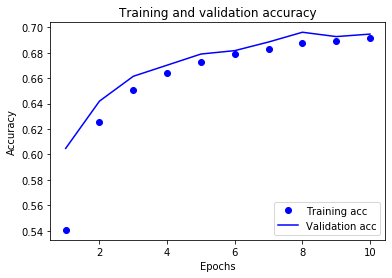

In [61]:
plt.clf() 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [62]:
def logits_to_text(logits, tokenizer):
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

# Test Data

In [63]:
# Reshape the test data 
test_x = pad(preproc_english_sentences_test, max_french_sequence_length_test)
test_x = test_x.reshape((-1, preproc_french_sentences_train.shape[-2], 1))

# Rehsape the test label data to fit the model
preproc_french_sentences_test = preproc_french_sentences_test.reshape((-1, preproc_french_sentences_train.shape[-2], 1))

# Evaluate the model on the unseen test data
simple_rnn_model_score = model.evaluate(test_x, preproc_french_sentences_test, verbose=0)

print("Simple model accuracy on unseen test dataset: {0:.2f}%".format(simple_rnn_model_score[1]*100))

Simple model accuracy on unseen test dataset: 9.02%


In [64]:
print(logits_to_text(model.predict(tmp_x[:1])[0], french_tokenizer_train))

en plus est est en en dã©cembre en est est en en mai en <PAD> l' l' juin de <PAD> <PAD>


# Encoder-Decoder

In [75]:
# Reshape the input
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

input_shape = tmp_x.shape
output_sequence_length = max_french_sequence_length
english_vocab_size = english_vocab_size + 1
french_vocab_size  = french_vocab_size + 1

In [76]:
# Build the encoder-decoder RNN model
input_layer= Input(shape=input_shape[1:])
encoder = GRU(256, recurrent_dropout=0.2)(input_layer)
repeat_vector = RepeatVector(output_sequence_length)(encoder)
decoder = GRU(256, return_sequences=True, recurrent_dropout=0.2)(repeat_vector)
dense_layer = Dense(french_vocab_size, activation='relu')(decoder)
output_layer = TimeDistributed(Dense(french_vocab_size, activation='softmax'))(decoder)

In [77]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 21, 1)             0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 21, 1024)          1579008   
_________________________________________________________________
dense_5 (Dense)              (None, 21, 702)           719550    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 21, 351)           246753    
Total params: 2,545,311
Trainable params: 2,545,311
Non-trainable params: 0
_________________________________________________________________


In [78]:
# Compile the model
model.compile( loss=sparse_categorical_crossentropy,
               optimizer=Adam(lr = 0.01),
               metrics=['accuracy'])

In [79]:
%time history = model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)

Train on 110288 samples, validate on 27573 samples
Epoch 1/10


ResourceExhaustedError:  OOM when allocating tensor with shape[1024,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradients_4/zeros_like_22 (defined at C:\Users\harka\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_59071]

Function call stack:
keras_scratch_graph


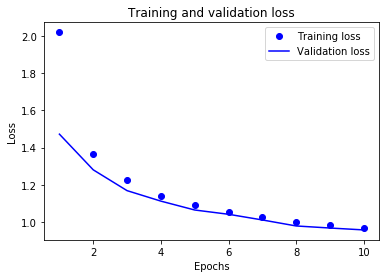

In [70]:
import matplotlib.pyplot as plt
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

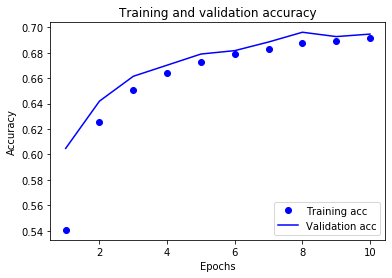

In [71]:
plt.clf() 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [72]:
def logits_to_text(logits, tokenizer):
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

# Test Data

In [73]:
# Reshape the test data 
test_x = pad(preproc_english_sentences_test, max_french_sequence_length_test)
test_x = test_x.reshape((-1, preproc_french_sentences_train.shape[-2], 1))

# Rehsape the test label data to fit the model
preproc_french_sentences_test = preproc_french_sentences_test.reshape((-1, preproc_french_sentences_train.shape[-2], 1))

# Evaluate the model on the unseen test data
simple_rnn_model_score = model.evaluate(test_x, preproc_french_sentences_test, verbose=0)

print("Simple model accuracy on unseen test dataset: {0:.2f}%".format(simple_rnn_model_score[1]*100))

Simple model accuracy on unseen test dataset: 9.02%


In [74]:
print(logits_to_text(model.predict(tmp_x[:1])[0], french_tokenizer_train)) 

en plus est est en en dã©cembre en est est en en mai en <PAD> l' l' juin de <PAD> <PAD>
